<a href="https://colab.research.google.com/github/ceabrett/tf_course/blob/master/w1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting whether a light is on or off

I have collected the data for one of my lights over a period of about 2 months. In this exercise we will train a tensorflow model to predict the state of the light from the following featuers:
* hour of the day
* day of the week
* minutes since the last state change in the home (log scaled)
* miuntes since the last utterance in the home (log scaled)
* the elevation of the sun (scaled between -1 and -1)
* mean onoff state (the proportion of other lights in the home that are on)

**Exercise:** Which of these features would you expect to be the most important? Can you think of any other features that would help?

First lets executre the code from the lecture and the code from the slides, just to make sure it works.

In [0]:
# import some modules that we will use in the notebook
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

In [0]:
# code from the week 1 lectures
model = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')

xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

model.fit(xs, ys, epochs=10)

print("prediction = %s" % model.predict([1]))

Epoch 1/10
6/6 [==============================] - 1s 100ms/sample - loss: 55.4513
Epoch 2/10
6/6 [==============================] - 0s 714us/sample - loss: 44.0409
Epoch 3/10
6/6 [==============================] - 0s 669us/sample - loss: 35.0553
Epoch 4/10
6/6 [==============================] - 0s 427us/sample - loss: 27.9775
Epoch 5/10
6/6 [==============================] - 0s 428us/sample - loss: 22.4008
Epoch 6/10
6/6 [==============================] - 0s 297us/sample - loss: 18.0054
Epoch 7/10
6/6 [==============================] - 0s 342us/sample - loss: 14.5394
Epoch 8/10
6/6 [==============================] - 0s 406us/sample - loss: 11.8049
Epoch 9/10
6/6 [==============================] - 0s 552us/sample - loss: 9.6460
Epoch 10/10
6/6 [==============================] - 0s 440us/sample - loss: 7.9401
prediction = [[1.0211489]]


In [3]:
# code from the slides
model = tf.keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=[1], activation="relu"))
model.add(keras.layers.Dense(2, activation="softmax"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

xs = np.array([-1.0, 2.0, -3.0, 4.0, -5.0, 6.0], dtype=float)
ys = np.array([[0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0]], dtype=float)

model.fit(xs, ys, epochs=10)

print("prediction = %s" % model.predict([-2, 2]))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
6/6 [==============================] - 0s 73ms/sample - loss: 0.4599 - acc: 0.5000
Epoch 2/10
6/6 [==============================] - 0s 395us/sample - loss: 0.4589 - acc: 1.0000
Epoch 3/10
6/6 [==============================] - 0s 361us/sample - loss: 0.4580 - acc: 1.0000
Epoch 4/10
6/6 [==============================] - 0s 420us/sample - loss: 0.4570 - acc: 1.0000
Epoch 5/10
6/6 [=============================

**Exercise:** Do the above predictions look correct?

Now lets load my smart home dataset.

In [7]:
# make the dataset accessible to this notebook
!git clone https://github.com/ceabrett/tf_course.git

# load the dataset into a pandas dataframe and show the beginning of the dataset
df = pd.read_csv("tf_course/data.csv")
df.head()

Cloning into 'tf_course'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 56 (delta 27), reused 16 (delta 5), pack-reused 0
Unpacking objects: 100% (56/56), done.


,dow_f,hour_f,log_mins_since_any_onoff,log_mins_since_utt,mean_onoff_state,state,sun_elevation
0,3.666667,16.00,3.418493,6.053619,0.2,1,0.024071
1,3.677083,16.25,3.818226,6.088252,0.2,1,0.004045
2,3.687500,16.50,4.103030,6.121726,0.2,1,-0.016666
3,3.697917,16.75,4.324442,6.154116,0.2,1,-0.047375
4,3.708333,17.00,1.963954,1.368262,0.4,1,-0.073805


In [6]:
# some summary statistics about the data
df.describe()

NameError: ignored

We want to predict "state" using everything else as a feature, so lets seperate them. Tensorflow expects us to pass seperately the features and the label to the fit function.

In [8]:
# to keep things simple initially, lets just use 1 feature, "hour_f"
feat_names = ["hour_f"]

# later we can use all features by uncommenting the below line
#feat_names = [feat_name for feat_name in df.columns if feat_name != "state"]

feats = df[feat_names]
label = df["state"]

# tensorflow is expecting the features vector to be a 2 dimensional array, not a pandas dataframe. But we can get the underlying array with .values
xs_light = feats.values
ys_light = label.values

# for classification into 2 classes our output dimension should be 2
# currently ys looks like [0, 1, 0 ...], but we want [[0, 1], [1, 0], [0, 1],..]
# luckily there is a helper function which does this mapping for us
from keras.utils import np_utils
ys_light = np_utils.to_categorical(ys_light, 2)

Using TensorFlow backend.


Now lets train our classification model on the real data.

In [9]:
# code from the slides
model = tf.keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=[1], activation="relu"))
model.add(keras.layers.Dense(2, activation="softmax"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

model.fit(xs_light, ys_light, epochs=10)

print("prediction = %s" % model.predict([4, 17]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5953/5953 [==============================] - 0s 64us/sample - loss: 0.6575 - acc: 0.7361
Epoch 2/10
5953/5953 [==============================] - 0s 39us/sample - loss: 0.6115 - acc: 0.7361
Epoch 3/10
5953/5953 [==============================] - 0s 40us/sample - loss: 0.5905 - acc: 0.7361
Epoch 4/10
5953/5953 [==============================] - 0s 41us/sample - loss: 0.5821 - acc: 0.7361
Epoch 5/10
5953/5953 [==============================] - 0s 40us/sample - loss: 0.5789 - acc: 0.7361
Epoch 6/10
5953/5953 [======================

**Exercise:** Do these predictions make sense?

Let's visualize our model to see if we can better understand what is going on.

predictions = [[0.86153257 0.13846742]
 [0.86002296 0.13997707]
 [0.8498493  0.15015078]
 [0.83907443 0.16092557]
 [0.82768327 0.17231677]
 [0.81566286 0.18433717]
 [0.8030035  0.19699651]
 [0.7896989  0.21030107]
 [0.7757468  0.22425324]
 [0.7611489  0.23885104]
 [0.74591184 0.25408813]
 [0.7300479  0.26995215]
 [0.7135736  0.28642648]
 [0.696512   0.30348805]
 [0.67889124 0.32110876]
 [0.66074574 0.33925426]
 [0.6421154  0.3578846 ]
 [0.6230459  0.3769541 ]
 [0.60358727 0.39641264]
 [0.58379525 0.41620466]
 [0.5637303  0.43626973]
 [0.54345345 0.45654652]
 [0.5230316  0.47696838]]


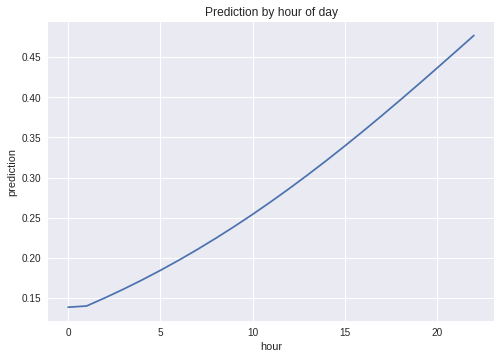

In [0]:
import matplotlib.pyplot as plt

def plot(model):
  # plot one point for each hour of the day
  hours = range(23)
  preds = model.predict(hours)
  print("predictions = %s" % preds)
  plt.plot(hours, preds[:, -1])
  plt.xlabel("hour")
  plt.ylabel("prediction")
  plt.title("Prediction by hour of day")
  
plot(model)

OK, so later in the day it is more likely that the light is on. This is a believable pattern. But the fitted pattern seems overly simplistic. We can do better.

In [11]:
# lets get more advanced and do a little "feature engineering"

xs_light = df[["hour_f"]].values
print("xs before: %s" % xs_light)

# some magic math operations to convert this into a 2 dimensional variable
import math
def transform_hour(xs):
  xs_cos = np.cos((2 * math.pi * xs) / 24.0)
  xs_sin = np.sin((2 * math.pi * xs) / 24.0)
  xs = np.concatenate([xs_cos, xs_sin], axis=1)
  return xs

xs_light = transform_hour(xs_light)
print("xs after: %s" % xs_light)

xs before: [[16.  ]
 [16.25]
 [16.5 ]
 ...
 [15.5 ]
 [15.75]
 [16.  ]]
xs after: [[-0.5        -0.8660254 ]
 [-0.44228869 -0.89687274]
 [-0.38268343 -0.92387953]
 ...
 [-0.60876143 -0.79335334]
 [-0.55557023 -0.83146961]
 [-0.5        -0.8660254 ]]


In [12]:
# train a model with these features
model = tf.keras.Sequential()
model.add(keras.layers.Dense(32, input_shape=[2], activation="relu"))
model.add(keras.layers.Dense(2, activation="softmax"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

model.fit(xs_light, ys_light, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5953/5953 [==============================] - 0s 70us/sample - loss: 0.5333 - acc: 0.7504
Epoch 2/10
5953/5953 [==============================] - 0s 47us/sample - loss: 0.4537 - acc: 0.7808
Epoch 3/10
5953/5953 [==============================] - 0s 49us/sample - loss: 0.4452 - acc: 0.7852
Epoch 4/10
5953/5953 [==============================] - 0s 48us/sample - loss: 0.4418 - acc: 0.7835
Epoch 5/10
5953/5953 [==============================] - 0s 50us/sample - loss: 0.4399 - acc: 0.7821
Epoch 6/10
5953/5953 [==================

[[0.9543782  0.04562187]
 [0.98162156 0.01837841]
 [0.98921853 0.01078141]
 [0.9905178  0.00948218]
 [0.9882637  0.01173629]
 [0.9808429  0.01915714]
 [0.9610538  0.03894621]
 [0.9121164  0.08788361]
 [0.8022904  0.19770958]
 [0.68789196 0.31210804]
 [0.70472604 0.2952739 ]
 [0.7341372  0.26586288]
 [0.76035357 0.23964652]
 [0.77363163 0.22636835]
 [0.7439275  0.2560725 ]
 [0.6497805  0.3502195 ]
 [0.5252374  0.47476265]
 [0.39862207 0.60137796]
 [0.35485595 0.64514405]
 [0.34257007 0.65743   ]
 [0.36222312 0.6377769 ]
 [0.4856828  0.5143173 ]
 [0.6887541  0.31124592]]
predictions = [[0.9543782  0.04562187]
 [0.98162156 0.01837841]
 [0.98921853 0.01078141]
 [0.9905178  0.00948218]
 [0.9882637  0.01173629]
 [0.9808429  0.01915714]
 [0.9610538  0.03894621]
 [0.9121164  0.08788361]
 [0.8022904  0.19770958]
 [0.68789196 0.31210804]
 [0.70472604 0.2952739 ]
 [0.7341372  0.26586288]
 [0.76035357 0.23964652]
 [0.77363163 0.22636835]
 [0.7439275  0.2560725 ]
 [0.6497805  0.3502195 ]
 [0.525237

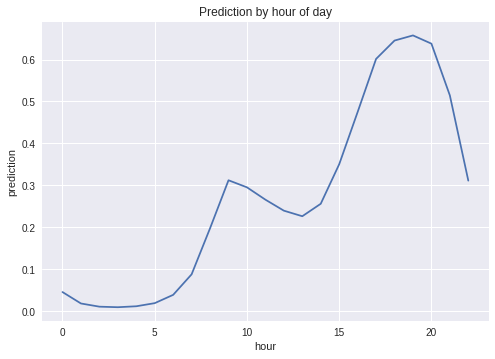

In [14]:
import matplotlib.pyplot as plt
def plot(model):
  # plot one point for each hour of the day
  hours = np.array([[h] for h in range(23)])
  hours_transformed = transform_hour(hours)
  preds = model.predict(hours_transformed)
  print(preds)
  print("predictions = %s" % preds)
  plt.plot(hours, preds[:, -1])
  plt.xlabel("hour")
  plt.ylabel("prediction")
  plt.title("Prediction by hour of day")
  
plot(model)

That's more like it! A peak in the morning and a peak in the evening. This model is now prediction in a way that is much more consistent with observed historical patterns.

**Exercise:** So far we have only used 1 feature, the hour of the day. Go back and train a model using all the features. The accuracy should improve a lot.

**Exercise:** Follow the instructions on the slides to train a keras model in Eider, the amazon internal tool